In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d deepul/homeworks/hw3/data
!rm hw3_data.zip
!pip install ./deepul

In [3]:
from deepul.hw3_helper import *

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


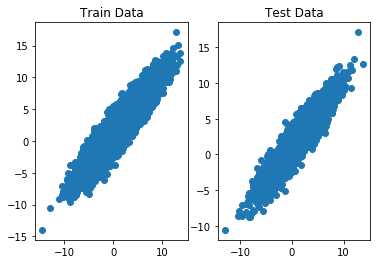

Dataset 2


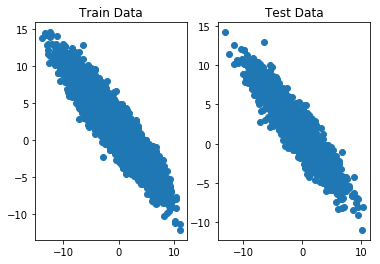

In [2]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




In [145]:
import torch
import torch.nn as nn
import numpy as np

class Encoder(nn.Module):
    def __init__(self, input_shape=2, hidden_shape=64, output_shape=2):
        super().__init__()
        self.hidden1 = nn.Linear(input_shape, hidden_shape)
        self.hidden2 = nn.Linear(hidden_shape, hidden_shape)
        self.hidden3 = nn.Linear(hidden_shape, output_shape)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        return self.hidden3(x)
        
class Decoder(nn.Module):
    def __init__(self, input_shape=2, hidden_shape=64, output_shape=2):
        super().__init__()
        self.hidden1 = nn.Linear(input_shape, hidden_shape)
        self.hidden2 = nn.Linear(hidden_shape, hidden_shape)
        self.hidden3 = nn.Linear(hidden_shape, hidden_shape)
        self.hidden4 = nn.Linear(hidden_shape, output_shape)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        return self.hidden4(x)
#output log_sd instead of sd, more stable
class VAE(nn.Module):
    def __init__(self, input_shape=2, hidden_shape=64, latent=32):
        super().__init__()
        self.latent = 32
        self.encoder = Encoder(input_shape=input_shape, output_shape=2*latent)
        self.decoder = Decoder(input_shape=latent, output_shape=2*input_shape)
        
    def forward(self, x):
        z_mean, z_log_sd = self.encoder(x).chunk(2, dim=1)
        z = z_mean + z_log_sd*torch.torch.randn(z_mean.shape)
        x_mean, x_log_sd = self.decoder(z).chunk(2, dim=1)
        return z_mean, z_log_sd, x_mean, x_log_sd
    
    def samples(self, noise=True):
        z = torch.randn(1000, self.latent)
        mean, log_sd = self.decoder(z).chunk(2, dim=1)
        if noise: return (torch.randn(mean.shape) * torch.exp(log_sd) + mean).detach().numpy()
        else: return mean.detach().numpy()


Final -ELBO: -0.5454, Recon Loss: -0.6880, KL Loss: 0.1426


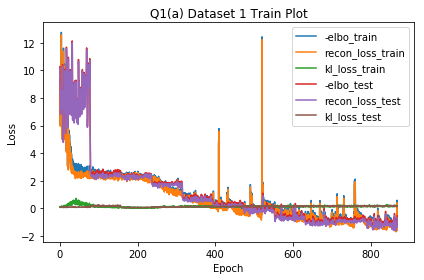

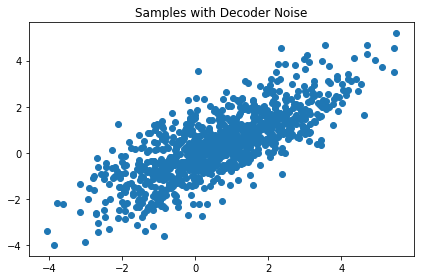

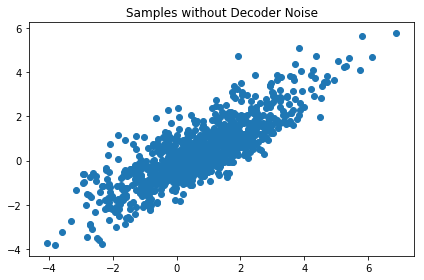

In [166]:
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
def train(train_loader, test_loader, model, optimizer, epochs=1):
    train_loss = []
    test_loss = []
    for data in test_loader:
            z_mean, z_log_sd, x_mean, x_log_sd = model(data)
            KL_loss = 0.5 * (torch.exp(z_log_sd) + z_mean**2 - 1 - z_log_sd).mean()
            Recon_loss = -Normal(x_mean, torch.exp(x_log_sd)).log_prob(data).mean()
            loss = KL_loss + Recon_loss
            test_loss.append([loss.item(), Recon_loss.item(), KL_loss.item()])
    for epoch in range(epochs):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            z_mean, z_log_sd, x_mean, x_log_sd = model(data)
            KL_loss = 0.5 * (torch.exp(z_log_sd) + z_mean**2 - 1 - z_log_sd).mean()
            Recon_loss = -Normal(x_mean, torch.exp(x_log_sd)).log_prob(data).mean()
            loss = KL_loss + Recon_loss
            loss.backward()
            optimizer.step()
            train_loss.append([loss.item(), Recon_loss.item(), KL_loss.item()])
        model.eval()
        for data in test_loader:
            z_mean, z_log_sd, x_mean, x_log_sd = model(data)
            KL_loss = 0.5 * (torch.exp(z_log_sd) + z_mean**2 - 1 - z_log_sd).mean()
            Recon_loss = -Normal(x_mean, torch.exp(x_log_sd)).log_prob(data).mean()
            loss = KL_loss + Recon_loss
            test_loss.append([loss.item(), Recon_loss.item(), KL_loss.item()])
    return train_loss, test_loss

def q1(train_data, test_data, part, dset_id):
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32)
    model = VAE()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    train_loss, test_loss = train(train_loader, test_loader, model, optimizer, epochs=10)
    model.eval()
    sample_noise = model.samples(noise=True)
    sample_nonnoise = model.samples(noise=False)
    return np.array(train_loss), np.array(test_loss), sample_noise, sample_nonnoise
q1_save_results('a', 1, q1)

Final -ELBO: -1.6084, Recon Loss: -1.7212, KL Loss: 0.1129


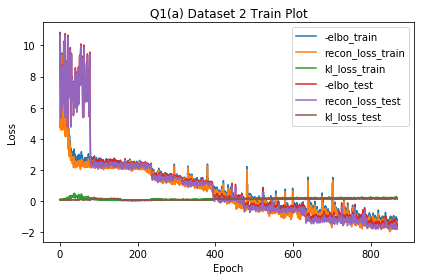

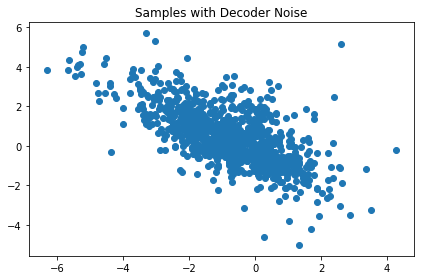

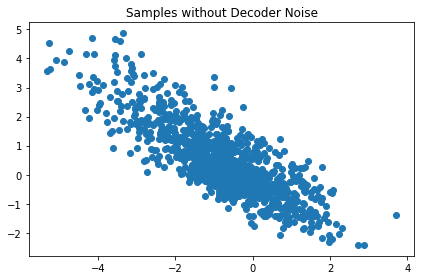

In [167]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


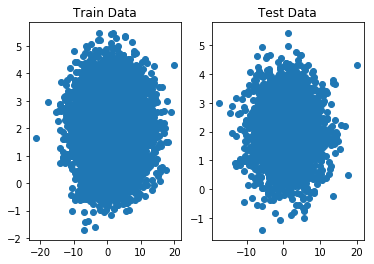

Dataset 2


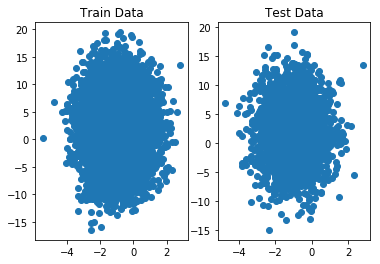

In [168]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

Final -ELBO: 0.5922, Recon Loss: 0.5212, KL Loss: 0.0710


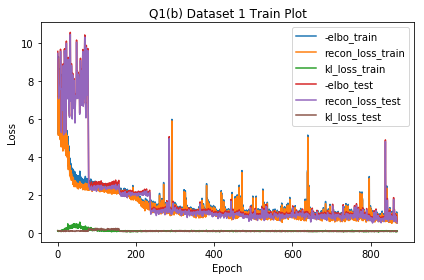

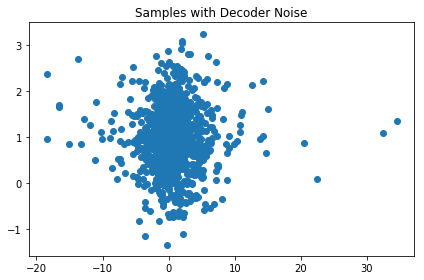

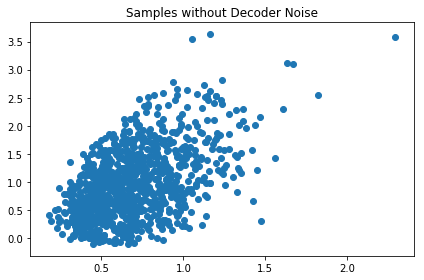

In [169]:
q1_save_results('b', 1, q1)

Final -ELBO: 0.5103, Recon Loss: 0.4355, KL Loss: 0.0747


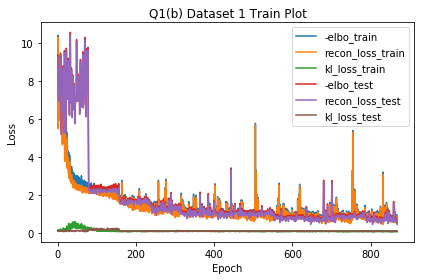

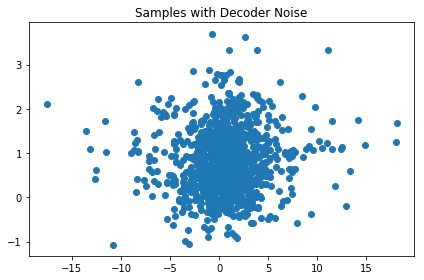

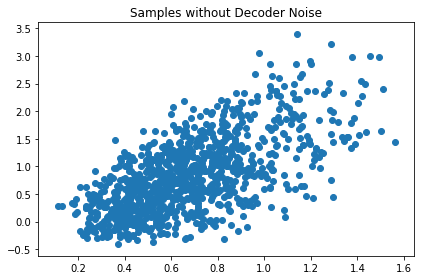

In [170]:
q1_save_results('b', 1, q1)

## Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and <a href=http://ufldl.stanford.edu/housenumbers/>SVHN<a>).

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



In [0]:
from deepul.hw3_helper import *
import torch
import torch.nn as nn
class Encoder(nn.Module):
    def __init__(self, latent):
        super().__init__()
        self.latent = latent
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 2, 1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(4 * 4 * 256, 2 * latent)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x).view(x.shape[0], -1)
        return self.fc(x)
    
class Decoder(nn.Module):
    def __init__(self, latent):
        super().__init__()
        self.latent = latent
        self.fc = nn.Linear(latent, 4 * 4 * 128)
        self.tconv1 = nn.ConvTranspose2d(128, 128, 4, 2, 1)
        self.tconv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.tconv3 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.conv1 = nn.Conv2d(32, 3, 3, 1, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc(x)).reshape(x.shape[0], 128, 4, 4)
        x = self.relu(self.tconv1(x))
        x = self.relu(self.tconv2(x))
        x = self.relu(self.tconv3(x))
        return self.conv1(x)

class VAE(nn.Module):
    def __init__(self, latent=16):
        super().__init__()
        self.latent = latent
        self.encoder = Encoder(latent)
        self.decoder = Decoder(latent)
        
    def forward(self, x):
        x = 2 * x - 1
        z_mean, z_log_sd = self.encoder(x).chunk(2, dim=1)
        z = z_mean + torch.randn(z_mean.shape, device='cuda') * torch.exp(z_log_sd)
        xd = self.decoder(z)
        return z_mean, z_log_sd, xd
    
    def samples(self):
        z = torch.randn(100, self.latent)
        samples = torch.clamp(self.decoder(z.cuda()), -1, 1)
        return samples.permute(0, 2, 3, 1).detach().cpu().numpy() * 0.5 + 0.5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Final -ELBO: 107.0600, Recon Loss: 82.5141, KL Loss: 24.5459


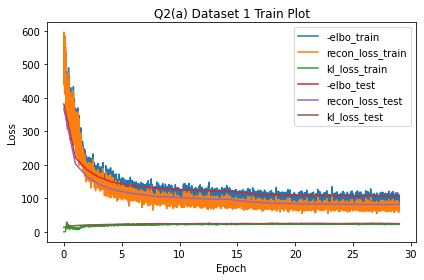

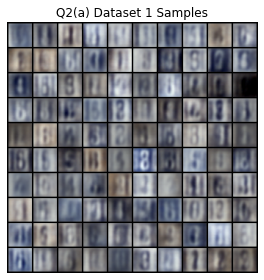

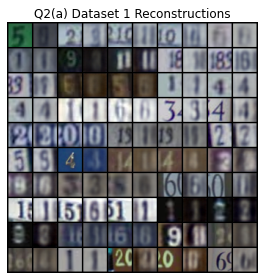

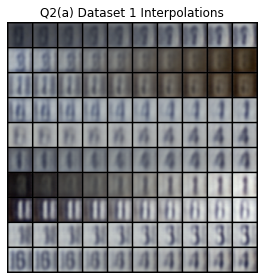

In [0]:
from tqdm import tqdm_notebook as tqdm
def train(train_loader, test_loader, model, optimizer, recon_loss, epochs=1):
    train_loss = []
    test_loss = []
    for data in test_loader:
            z_mean, z_log_sd, xd = model(data.cuda())
            KL_loss = 0.5 * (torch.exp(2*z_log_sd) + z_mean**2 - 1 - 2*z_log_sd).sum(1).mean()
            Recon_loss = recon_loss(xd, data.cuda()).sum(1).mean()
            loss = KL_loss + Recon_loss
            test_loss.append([loss.item(), Recon_loss.item(), KL_loss.item()])
    for epoch in tqdm(range(epochs)):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            z_mean, z_log_sd, xd = model(data.cuda())
            KL_loss = 0.5 * (torch.exp(2*z_log_sd) + z_mean**2 - 1 - 2*z_log_sd).sum(1).mean()
            Recon_loss = recon_loss(xd, data.cuda()).sum(1).mean()
            loss = KL_loss + Recon_loss
            loss.backward()
            optimizer.step()
            train_loss.append([loss.item(), Recon_loss.item(), KL_loss.item()])
            
        model.eval()
        for data in test_loader:
            z_mean, z_log_sd, xd = model(data.cuda())
            KL_loss = 0.5 * (torch.exp(2*z_log_sd) + z_mean**2 - 1 - 2*z_log_sd).sum(1).mean()
            Recon_loss = recon_loss(xd, data.cuda()).sum(1).mean()
            loss = KL_loss + Recon_loss
            test_loss.append([loss.item(), Recon_loss.item(), KL_loss.item()])
    return train_loss, test_loss

def get_pairs(model, data):
    data = 2 * data - 1
    z_mean, z_log_sd, xd = model(data.cuda())
    recon = torch.stack((data.cuda(), torch.clamp(xd, -1, 1)), dim=1).reshape(-1, 3, 32, 32) * 0.5 + 0.5
    return recon.permute(0, 2, 3, 1).detach().cpu().numpy() * 255

def get_interpolations(model, data):
    values = []
    data = 2 * data - 1
    z_mean, z_log_sd = model.encoder(data.cuda()).chunk(2, dim=1)
    z1, z2 = z_mean.chunk(2, 0)
    for alpha in np.linspace(0, 1, 10):
        values.append(model.decoder(z1 * (1 - alpha) + z2 * alpha))
    values = torch.stack(values, dim=1).view(100, 3, 32, 32)
    values = torch.clamp(values, -1, 1) * 0.5 + 0.5
    return values.permute(0, 2, 3, 1).detach().cpu().numpy() * 255
    
def q2_a(train_data, test_data, dset_id):
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=50)
    model = VAE().cuda()
    recon_loss = nn.MSELoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr=.001)
    train_loss, test_loss = train(train_loader, test_loader, model, optimizer, recon_loss, epochs=30)
    samples = model.samples() * 255.
    pairs = get_pairs(model, next(iter(test_loader))[:50])
    interpolations = get_interpolations(model, next(iter(test_loader))[:20])
    return np.array(train_loss), np.array(test_loss), samples, pairs, interpolations
q2_save_results('a', 1, q2_a)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Final -ELBO: 240.6540, Recon Loss: 209.2483, KL Loss: 31.4057


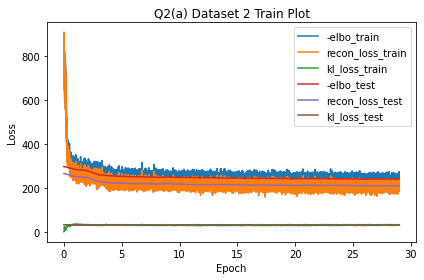

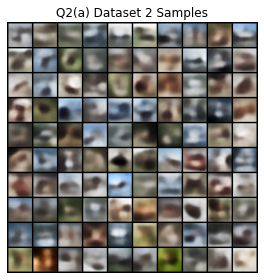

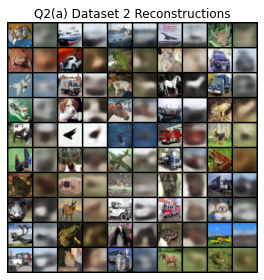

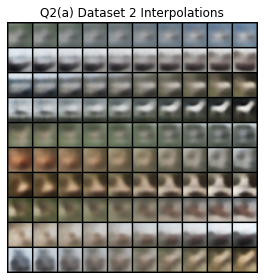

In [0]:
q2_save_results('a', 2, q2_a)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   For dataset 1, use a single Type A masked convolutions followed by 10 residual blocks (same as HW 1), and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   For dataset 2, use the same architecture as above but with 15 residual blocks
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves. 
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

In [ ]:
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
from deepul.hw3_helper import *
import torch
#all pixel cnn from previous codes
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(dim)
        self.bn2 = nn.BatchNorm2d(dim)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(dim, dim, 3, 1, 1)
        self.conv2 = nn.Conv2d(dim, dim, 1, 1, 0)
        
    def forward(self, x):
        xd = self.relu(self.bn1(x))
        xd = self.bn2(self.conv1(xd))
        return x + self.conv2(self.relu(xd))

class MaskConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, conditional_size=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input, cond=None):
        return F.conv2d(input, self.weight * self.mask, self.bias, self.stride, self.padding, self.dilation, self.groups)

    def create_mask(self, mask_type):
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        if mask_type == 'B':
            self.mask[:, :, k // 2, k // 2] = 1

class PixelCNNResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.ModuleList([
            nn.ReLU(),
            MaskConv2d('B', dim, dim // 2, 1),
            nn.ReLU(),
            MaskConv2d('B', dim // 2, dim // 2, 3, padding=1),
            nn.ReLU(),
            MaskConv2d('B', dim // 2, dim, 1)
        ])

    def forward(self, x, cond=None):
        out = x
        for layer in self.block:
            out = layer(out)
        return x + out


class PixelCNN(nn.Module):
    def __init__(self, h, w, K, D=256, no_layers=7):
        super().__init__()
        self.embedding = nn.Embedding(K, D)
        model = nn.ModuleList([MaskConv2d('A', D, D, 7, padding=3), nn.ReLU()])
        for _ in range(no_layers - 1):
            model.append(PixelCNNResBlock(D))
        model.extend([nn.ReLU(), MaskConv2d('B', D, 512, 1), nn.ReLU(), MaskConv2d('B', 512, K, 1)])
        self.net = model
        self.h = h
        self.w = w
        self.K = K

    def forward(self, x):
        out = self.embedding(x.cuda()).permute(0, 3, 1, 2)
        for layer in self.net:
            out = layer(out)
        return out

    def loss(self, x):
        return F.cross_entropy(self(x), x)

    def sample(self):
        samples = torch.zeros(100, self.h, self.w).long()
        with torch.no_grad():
            for r in range(self.h):
                for c in range(self.w):
                    out = self(samples)[:, :, r, c]
                    out = F.softmax(out, dim=1)
                    samples[:, r, c] = torch.multinomial(out, 1).squeeze(-1)
        return samples
        
#do not use nn.init here, reduces performance
class Lookup(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.K = K
        self.D = D
        self.embed = nn.Embedding(K, D)
        self.embed.weight.data.uniform_(-1./K,1./K)
        
    def forward(self, x):
        bs, ch, h, w = x.shape
        xd = x.permute(0, 2, 3, 1).reshape(-1, self.D) #resultant shape bsxHxW x D
        squared_l2 = (xd**2).sum(dim=1, keepdim=True) + (self.embed.weight.t()**2).sum(dim=0, keepdim=True) \
                    - 2 * torch.mm(xd, self.embed.weight.t()) #64x1 - 64x128 + 1x128 = 64x128
        idx = torch.argmax(-squared_l2, dim=1).view(bs, h, w) #argmin 
        values = self.embed(idx).permute(0, 3, 1, 2)
        return values, (values - x).detach() + x,  idx
     
#splitting into individual modules damages the samples. ??
class VAE(nn.Module):
    def __init__(self, D, K):
        super().__init__()
        self.K = K
        self.lookup = Lookup(K, D)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 4, 2, 1),
            ResidualBlock(256),
            ResidualBlock(256),
        )
        self.decoder = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 3, 4, 2, 1),
            nn.Tanh(),
        )

    def encode(self, x):
        with torch.no_grad():
            x = 2 * x - 1
            z = self.encoder(x.cuda())
            indices = self.lookup(z)[2]
            return indices

    def decode(self, z):
        with torch.no_grad():
            z = self.lookup.embed(z.cuda()).permute(0, 3, 1, 2)
            return self.decoder(z.cuda()).permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5

    def forward(self, x):
        z = self.encoder(x)
        e, ed, idx = self.lookup(z)
        return self.decoder(ed), torch.mean((z - e.detach()) ** 2)

    def loss(self, x):
        x = 2 * x - 1
        xd, diff = self(x)
        return F.mse_loss(xd, x) + diff


VQ-VAE Final Test Loss: 0.0533
PixelCNN Prior Final Test Loss: 1.7817


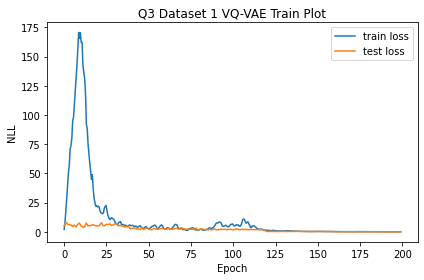

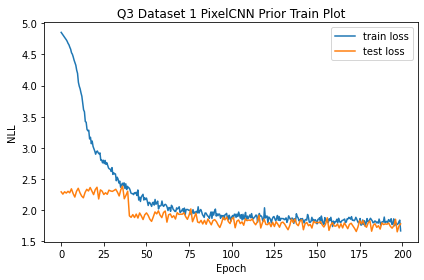

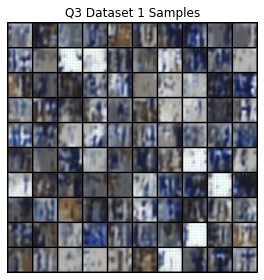

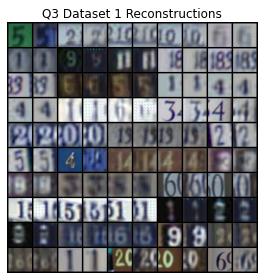

In [0]:
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import DataLoader
from deepul.hw3_helper import *

def train(train_loader, test_loader, model_, optimizer_, epochs=1, type_='vae'):
    train_loss, test_loss = [], []
    for epoch in tqdm(range(epochs), desc=type_):
        model_.train()
        for data in train_loader:
            optimizer_.zero_grad()
            loss = model_.loss(data.cuda())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_.parameters(), 1)
            optimizer_.step()
            train_loss.append(loss.item())
        model_.eval()
        for data in test_loader:
            loss = model_.loss(data.cuda())
            test_loss.append(loss.item())
    return train_loss, test_loss

def encoded_dataset(model_, loader):
    return torch.cat([model_.encode(data_) for data_ in loader])

def get_recon(model_, x):
    model_.eval()
    z = model_.encode(x)
    xd = model_.decode(z)
    return np.stack((x.cpu().permute(0, 2, 3, 1).numpy(), xd), axis=1).reshape((-1, 32, 32, 3)) * 255

def q3(train_data, test_data, dset_id):
    bs = 128
    ep = 10
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255).astype('float32')
    model = VAE(K=128, D=256).cuda()
    train_loader = DataLoader(train_data, shuffle=True, batch_size=bs)
    test_loader = DataLoader(test_data, batch_size=bs)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    train_loss, test_loss = train(train_loader, test_loader, model_=model, optimizer_=optimizer, epochs=ep, type_='vae')
    encoded_train_loader = DataLoader(encoded_dataset(model, train_loader), shuffle=True, batch_size=bs)
    encoded_test_loader = DataLoader(encoded_dataset(model, test_loader), batch_size=bs)
    h, w = next(iter(encoded_train_loader))[0].shape
    prior_model = PixelCNN(K=128, D=128, h=h, w=w, no_layers=10).cuda()
    prior_optimizer = torch.optim.Adam(prior_model.parameters(), lr=0.0001)
    prior_train_loss, prior_test_loss = train(encoded_train_loader, encoded_test_loader, model_=prior_model, 
                                              optimizer_=prior_optimizer, epochs=ep, type_='pixelcnn')
    prior_model.eval()
    samples = model.decode(prior_model.sample().long())* 255
    recon = get_recon(model, next(iter(test_loader))[:50].cuda())
    return np.array(train_loss), np.array(test_loss), np.array(prior_train_loss), np.array(prior_test_loss), samples, recon
q3_save_results(1, q3)


VQ-VAE Final Test Loss: 59.9933
PixelCNN Prior Final Test Loss: 1.7558


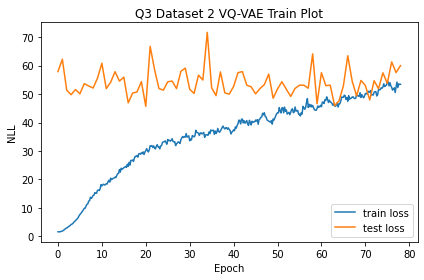

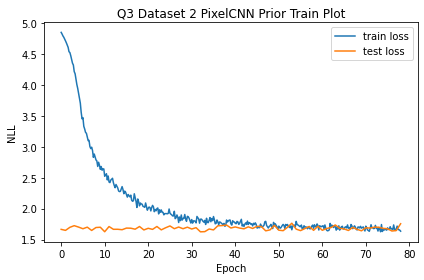

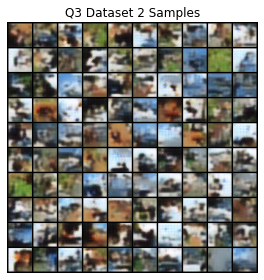

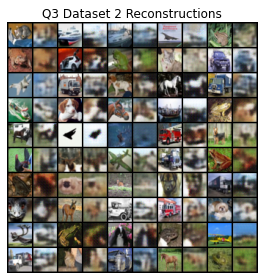

In [21]:
#train more epochs
q3_save_results(2, q3)